In [4]:
from os.path import dirname, join, abspath
from pyrep import PyRep
from pyrep.robots.arms.baxter import BaxterLeft, BaxterRight
from pyrep.robots.end_effectors.baxter_gripper import BaxterGripper
from pyrep.objects.dummy import Dummy
from pyrep.objects.shape import Shape
from pyrep.const import ObjectType, TextureMappingMode
from pyrep.objects.joint import Joint
from pyrep.objects.object import Object
from pyrep.objects.vision_sensor import VisionSensor
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler

import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import pickle
import pywt
from numpy import random
from pyrep.backend import sim

# random texture
import glob
import random
import imgaug.augmenters as iaa

import os

try:  
    os.mkdir("images") 
    os.mkdir("test") 
    os.mkdir("test/images") 
except OSError as error:  
    print(error)  
    

seq = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=0.03)])

[Errno 17] File exists: 'images'


## Loading vrep scene file

In [5]:

SCENE_FILE = 'scene_baxter_1.ttt'
#SCENE_FILE = 'scene_baxter_pick_and_pass.ttt'
pr = PyRep()

pr.launch(SCENE_FILE, headless=False)
pr.start()

baxter_left = BaxterLeft()
baxter_right = BaxterRight()
baxter_gripper_left = BaxterGripper(0)
baxter_gripper_right = BaxterGripper(1)

features = [Shape("f0"),Shape("f1"),Shape("f2"),Shape("f3"),Shape("f4"),Shape("f5"),
            Shape("f6"),Shape("f7"),Shape("f8"),Shape("f9"),Shape("f10"),Shape("f11"),
            Shape("f12"),Shape("f13"),Shape("f14"),Shape("f15"),Shape("f16"),Shape("f17"),
            Shape("f18"),Shape("f19"),Shape("f20")]

bg_list = glob.glob("sample_bg/*.jpg")

cams = [VisionSensor("Vision_sensor0"),VisionSensor("Vision_sensor1"),VisionSensor("Vision_sensor2"),
        VisionSensor("Vision_sensor3"),VisionSensor("Vision_sensor4"),VisionSensor("Vision_sensor5")]
pr.step()

## Functions for data generation

In [6]:


def get_camera_matrix(x_resolution = 640, y_resolution = 480, fov = np.pi/3):
    if (x_resolution/y_resolution) > 1:
        fov_x = fov
        fov_y = 2 * np.arctan(np.tan(fov/2) / (x_resolution/y_resolution))
    else:
        fov_x = 2 * np.arctan(np.tan(fov/2) / (x_resolution/y_resolution))
        fov_y = fov
    P = np.array([[-(x_resolution/2)/np.tan(0.5*fov_x),0,(x_resolution/2)],
                  [0,-(y_resolution/2)/np.tan(0.5*fov_y),(y_resolution/2)],
                  [0,0,1]])
    return P

def get_coor_by_P(v_pos, x_resolution = 640, y_resolution = 480, fov = np.pi/3):
    
    # find the field of view for x and y axis
    P = get_camera_matrix(x_resolution, y_resolution,fov)
    
    x = P @ v_pos.reshape((3,1))
    x = x/x[2]
    x.astype(int)

    return (int(x[0]),int(x[1]))

def add_data(features, cam, data_dict, count):
    image_name = "images/" + str(count) + ".png"
    image = cam.capture_rgb()
    image = seq(images=image)
    #image = add_gaussian_noise(image)
    image[image > 1] = 1
    image[image < 0] = 0
    n_feature = len(features)
    joints = np.zeros((n_feature,3))
    feature_to_delete = []
    for i in range(n_feature):
        if True: #check_visibility(features[i]):
            x,y = get_coor_by_P(features[i].get_position(cam))
            joints[i,:] = np.array([i,x,y])
        else:
            feature_to_delete.append(i)
    # delete no visiable features
    #joints = np.delete(joints,feature_to_delete,0)            
        
    data_dict[image_name] = joints.astype(int)
    plt.imsave(image_name,image)
    return data_dict


def set_background(filename):
    ConcreteFloor_list = [Shape("ConcreteFloor0"),Shape("ConcreteFloor1"),
                          Shape("ConcreteFloor2"),Shape("ConcreteFloor3"),
                          Shape("ConcreteFloor4"),Shape("ConcreteFloor5")]
    
    TEX_KWARGS = {
        'mapping_mode': TextureMappingMode.PLANE,
        'repeat_along_u': True,
        'repeat_along_v': True,
        "uv_scaling":[6.0,6.0],
    }
    text_ob, texture = pr.create_texture(filename)
    for floor in ConcreteFloor_list:
        floor.set_texture(texture, **TEX_KWARGS)
    pr.step()
    
def random_background():
    set_background(bg_list[random.randint(0,len(bg_list)-1)])

In [7]:

def reset_cams():
    for i in range(len(cams)):
        cams[i].set_pose(init_cam_pose[i])
    pr.step()
    
    
def set_light_position(position:list):
    Light = sim.simGetObjectHandle('Light')
    sim.simSetObjectPosition(Light,-1,position)
    pr.step()
    
def get_light_position():
    Light = sim.simGetObjectHandle('Light')
    return sim.simGetObjectPosition(Light,-1)

def reset_light():
    Light = sim.simGetObjectHandle('Light')
    sim.simSetObjectPosition(Light,-1,list(init_light_pose))
    pr.step()
    
def random_cam_position():
    for cam in cams:
        position = cam.get_pose() + np.random.normal(loc=0.0, scale=[0.03], size=(7))
        cam.set_pose(position)
    pr.step()
    
def random_lighting_position():
    l_position = get_light_position() + np.random.normal(loc=0.0, scale=[5], size=(3))
    set_light_position(list(l_position))
    
def random_part_color():
    for i in range(len(Baxter_bodypart_list)):
        color = init_part_color[i] + np.random.normal(loc = 0.0, scale = 0.03, size = 3)
        color = color.tolist()
        Baxter_bodypart_list[i].set_color(color) 
    pr.step()
    
def random_arm_configuration():
    joint = baxter_right.get_joint_positions()
    joint = joint + np.random.normal(loc = 0.0, scale = [0.1,0.3,0.3,0.3,0.3,0.3,0.3], size = 7)
    baxter_right.set_joint_positions(joint)
    joint = baxter_left.get_joint_positions()
    joint = joint + np.random.normal(loc = 0.0, scale = [0.1,0.3,0.3,0.3,0.3,0.3,0.3], size = 7)
    baxter_left.set_joint_positions(joint)
    


## Initialization

In [8]:
init_cam_pose = []
for cam in cams:
    init_cam_pose.append(cam.get_pose())
    

init_light_pose = get_light_position()

Baxter_bodypart_list = [Shape("Baxter_base_visible"),Shape("Baxter_lowerBody_visible"),
                        Shape("Baxter_upperBody_visible"),Shape("Baxter_monitor_visible"),
                        Shape("Baxter_leftArm_link2_visible"),Shape("Baxter_rightArm_link2_visible"),
                        Shape("Baxter_leftArm_link3_visible"),Shape("Baxter_rightArm_link3_visible"),
                        Shape("Baxter_leftArm_link4_visible"),Shape("Baxter_rightArm_link4_visible"),
                        Shape("Baxter_leftArm_link5_visible"),Shape("Baxter_rightArm_link5_visible"),
                        Shape("Baxter_leftArm_link6_visible"),Shape("Baxter_rightArm_link6_visible"),
                        Shape("Baxter_leftArm_link7_visible"),Shape("Baxter_rightArm_link7_visible"),
                        Shape("Baxter_leftArm_link8_visible"),Shape("Baxter_rightArm_link8_visible")]

init_part_color = []
for part in Baxter_bodypart_list:
    init_part_color.append(part.get_color())

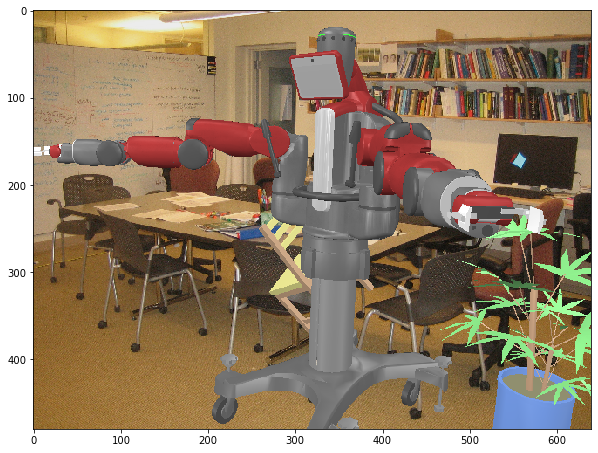

In [9]:
plt.figure(figsize = (10,10))
cam_id = 3
img = cams[cam_id].capture_rgb()

#for p in features:
#    x,y = get_coor_by_P(p.get_position(cams[cam_id]))
#    img = cv2.circle(img,(x,y), 5, (1,0,0), -1)
plt.imshow(img)


## Generating data

In [13]:
data_dict = {}
count = 0


In [ ]:
for i in range(200):
    print(i)
    if i % 10 == 0:
        pr.shutdown()
        time.sleep(1)
        pr.launch(SCENE_FILE, headless=False)
        pr.start()
        
    random_arm_configuration()
    random_lighting_position()
    random_background()
    random_cam_position()
    pr.step()
    for cam in cams:
        data_dict = add_data(features, cam, data_dict,count)
        count += 1
        time.sleep(0.01)
    reset_cams()


## save keypoint labels

In [17]:
filename = 'data'
outfile = open(filename,'wb')
pickle.dump(data_dict,outfile)
outfile.close()

In [25]:
# check saved data
filename = 'data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

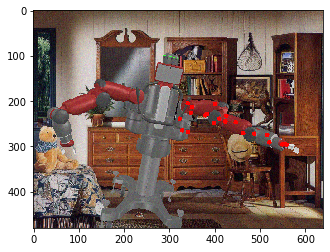

In [26]:
import matplotlib.pyplot as plt
idx = 0
img_file = "images/78.png"
img = cv2.imread(img_file)
for i in data_dict[img_file]:
    img = cv2.circle(img,tuple(i[1:]), 5, (0,0,255), -1)
    
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
#plt.show()

# Generating test data

In [18]:
data_dict = {}
count = 0

In [19]:
def add_data_test(features, cam, data_dict, count):
    image_name = "test/images/" + str(count) + ".png"
    image = cam.capture_rgb()
    image = seq(images=image)
    #image = add_gaussian_noise(image)
    image[image > 1] = 1
    image[image < 0] = 0
    n_feature = len(features)
    joints = np.zeros((n_feature,3))
    feature_to_delete = []
    for i in range(n_feature):
        if True: #check_visibility(features[i]):
            x,y = get_coor_by_P(features[i].get_position(cam))
            joints[i,:] = np.array([i,x,y])
        else:
            feature_to_delete.append(i)
    # delete no visiable features
    #joints = np.delete(joints,feature_to_delete,0)            
        
    data_dict[image_name] = joints.astype(int)
    plt.imsave(image_name,image)
    return data_dict

In [ ]:
for i in range(100):
    print(i)
    if i % 10 == 0:
        pr.shutdown()
        time.sleep(1)
        pr.launch(SCENE_FILE, headless=False)
        pr.start()
        
    random_arm_configuration()
    random_lighting_position()
    random_background()
    random_cam_position()
    pr.step()
    for cam in cams:
        data_dict = add_data_test(features, cam, data_dict,count)
        count += 1
        time.sleep(0.01)
    reset_cams()

In [22]:
filename = 'test/data'
outfile = open(filename,'wb')
pickle.dump(data_dict,outfile)
outfile.close()